## Brain Tumor Detection

Steps:
- median filter
- uses Tl, T2 images and undecimated wavelet transform for obtaining multiscale behavior
- gabor wavelet applied to approximations at all levels, and texture features are computed from the resulting filter outputs
- peaks are detected from the texture features and corresponding images are compared to determin the minimum pixel values
- The image thus obtained is given to the kmeans clustering algorithm, which gives the final segmented output.

imports

In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

import pywt
from skimage.filters import gabor

preprocessing

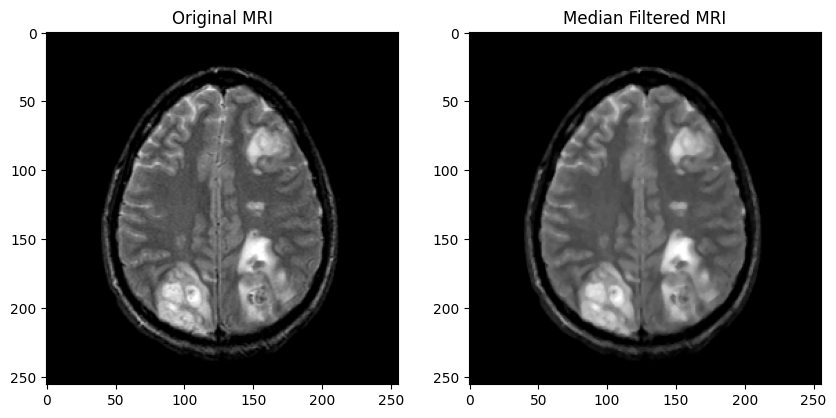

In [6]:
# mri = cv2.imread('images/meninglioma.jpg', cv2.IMREAD_GRAYSCALE)
mri = cv2.imread('images/sarcoma.png', cv2.IMREAD_GRAYSCALE)
# mri = cv2.imread('images/sarcoma.png', cv2.IMREAD_GRAYSCALE)
mri = cv2.resize(mri, (256, 256))

# median filter
mri_median = cv2.medianBlur(mri, 3)

# plot the images
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(mri, cmap='gray')
plt.title('Original MRI')

plt.subplot(122)
plt.imshow(mri_median, cmap='gray')
plt.title('Median Filtered MRI')

plt.show()



uses Tl, T2 images and undecimated wavelet transform for obtaining multiscale behavior


In [7]:
# Perform undecimated wavelet transform (UWT)
wavelet = 'db2'  # Daubechies wavelet
level = 3  # Number of decomposition levels
# coeffs = pywt.swt2(mri_median, wavelet, level=level, trim_approx=True)
coeffs = pywt.swt2(mri_median, wavelet, level=level, trim_approx=False)

# Extract approximation coefficients at all levels
approximations = [coeff[0] for coeff in coeffs]



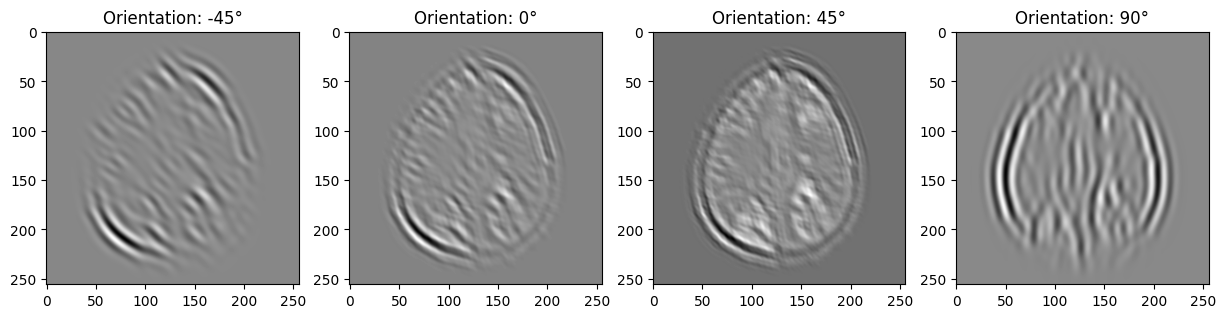

In [8]:
# Apply Gabor filters to the approximation images
gabor_features = []
frequencies = [0.1, 0.2, 0.3]  # Example frequencies
# orientations = [0, 45, 90, 135]  # Example orientations
orientations = [-45, 0, 45, 90]  # Example orientations

# frequencies = [0.05, 0.1, 0.2]  # Try varying frequencies
# orientations = [0, 45, 90, 135]  # Standard orientations


for approx in approximations:
    features_per_level = []
    for theta in orientations:
        for freq in frequencies:
            # Apply Gabor filter
            real, _ = gabor(approx, frequency=freq, theta=np.deg2rad(theta))
            features_per_level.append(real)
    gabor_features.append(features_per_level)

# Plot the Gabor features for one approximation level as an example
plt.figure(figsize=(15, 10))
for i, feature in enumerate(gabor_features[0][:len(orientations)]):  # Plot one frequency
    plt.subplot(2, len(orientations), i + 1)
    plt.imshow(feature, cmap='gray')
    plt.title(f'Orientation: {orientations[i]}°')
plt.show()




peaks are detected from the texture features and corresponding images are compared to determin the minimum pixel values
- The image thus obtained is given to the kmeans clustering algorithm, which gives the final segmented output.

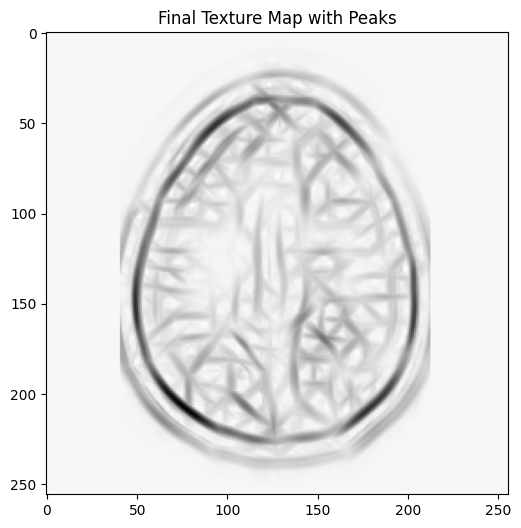

C:\Users\ARGHYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


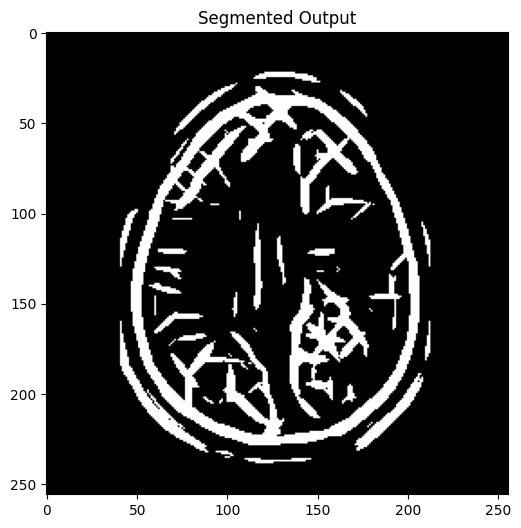

In [9]:
from scipy.ndimage import maximum_filter
from sklearn.cluster import KMeans

# Define a function for peak detection in 2D
def detect_peaks(image, threshold=0.1):
    """Detect peaks in the texture feature image using a local maximum filter."""
    neighborhood_size = 3  # Size of the neighborhood for maximum filtering
    local_max = maximum_filter(image, size=neighborhood_size)
    peaks = (image == local_max) & (image > threshold)
    return peaks

# Combine Gabor features into a single texture representation
combined_features = np.stack(
    [np.min(np.stack(level_features, axis=0), axis=0) for level_features in gabor_features],
    axis=0
)

# Detect peaks in each Gabor feature map and combine
peaks_combined = np.zeros_like(combined_features[0])  # Initialize with zeros
for level_features in combined_features:
    for feature_map in level_features:
        peaks = detect_peaks(feature_map, threshold=0.1)
        peaks_combined = np.maximum(peaks_combined, peaks)  # Combine peaks

# Compute the minimum pixel values across all levels
min_texture_map = np.min(combined_features, axis=0)

# Combine the peak map and minimum texture map for better segmentation
final_texture_map = min_texture_map * peaks_combined

# Plot the resulting map
plt.figure(figsize=(6, 6))
plt.imshow(final_texture_map, cmap='gray')
plt.title('Final Texture Map with Peaks')
plt.show()

# Reshape for clustering (flatten the 2D image into 1D for KMeans)
X = final_texture_map.flatten().reshape(-1, 1)

# Apply K-means clustering
n_clusters = 2  # Assume 2 clusters: tumor vs. background
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Reshape clustered labels back to the image shape
segmented_image = labels.reshape(final_texture_map.shape)

# Plot the segmented image
plt.figure(figsize=(6, 6))
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Output')
plt.show()


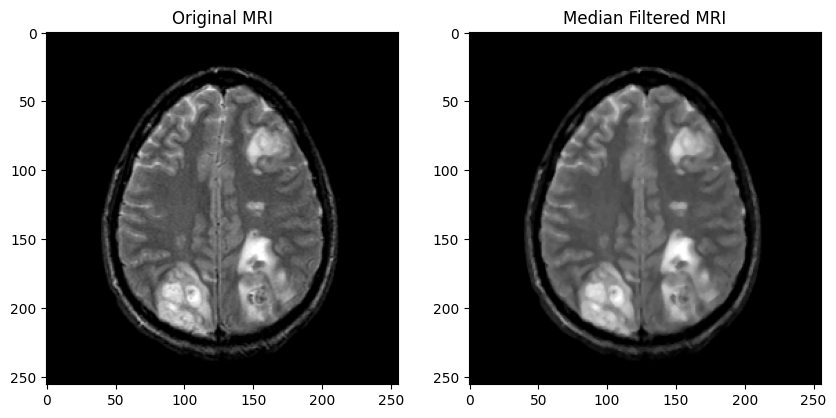

C:\Users\ARGHYA\AppData\Local\Temp\ipykernel_16664\117415408.py:52: RuntimeWarning: invalid value encountered in log2
  entropy_val = -np.sum(gabor_image * np.log2(gabor_image + np.finfo(float).eps))  # Entropy
C:\Users\ARGHYA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Variance: 90.79652967219532, Coefficient of Variation: 65.32160307294508
Variance: 7.076349930165724, Coefficient of Variation: 12.237968042533948
Variance: 1.0466679099433098, Coefficient of Variation: 4.041601519322004
Variance: 71.00989742264065, Coefficient of Variation: 94.78860302020601
Variance: 9.36002728632783, Coefficient of Variation: 24.1706163681888
Variance: 1.2493302968826157, Coefficient of Variation: 6.48545873984683
Variance: 46.503566820876706, Coefficient of Variation: 46.74824826078213
Variance: 4.434375098117846, Coefficient of Variation: 9.687704376278523
Variance: 0.7193960030248998, Coefficient of Variation: 3.3506807283513345
Variance: 72.69097730464301, Coefficient of Variation: 95.90404698232531
Variance: 9.798522934258358, Coefficient of Variation: 24.730305121756608
Variance: 1.289126165849138, Coefficient of Variation: 6.587942144069503
Variance: 25.114245800635512, Coefficient of Variation: 68.70878603629279
Variance: 6.066807996878939, Coefficient of Va

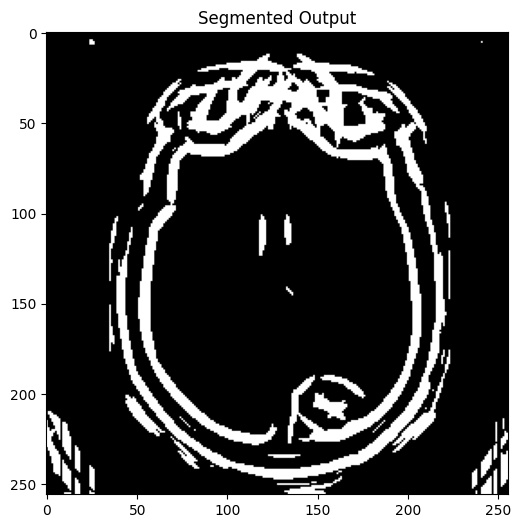

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from skimage.filters import gabor
from scipy.ndimage import maximum_filter
from scipy.stats import kurtosis, skew
from sklearn.cluster import KMeans


# Load the MRI image
mri = cv2.imread('images/sarcoma.png', cv2.IMREAD_GRAYSCALE)
mri = cv2.resize(mri, (256, 256))

# Apply median filter
mri_median = cv2.medianBlur(mri, 3)

# Plot the original and median filtered MRI
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(mri, cmap='gray')
plt.title('Original MRI')
plt.subplot(122)
plt.imshow(mri_median, cmap='gray')
plt.title('Median Filtered MRI')
plt.show()

# Perform Undecimated Wavelet Transform (SWT) with Biorthogonal B-spline wavelets
wavelet = 'bior1.3'  # Biorthogonal B-spline wavelet as used in the paper
level = 2  # Decompose up to the second level
coeffs = pywt.swt2(mri_median, wavelet, level=level)

# Extract approximation coefficients (LL subband at each level)
approximations = [coeff[0] for coeff in coeffs]

# Apply Gabor filters to the approximation images (LL subbands)
gabor_features = []
frequencies = [0.1, 0.2, 0.3]  # Example frequencies
orientations = [0, 45, 90, 135]  # Example orientations

for approx in approximations:
    features_per_level = []
    for theta in orientations:
        for freq in frequencies:
            # Apply Gabor filter
            real, _ = gabor(approx, frequency=freq, theta=np.deg2rad(theta))
            features_per_level.append(real)
    gabor_features.append(features_per_level)

# Function to compute texture features from Gabor filter outputs
def compute_texture_features(gabor_image):
    entropy_val = -np.sum(gabor_image * np.log2(gabor_image + np.finfo(float).eps))  # Entropy
    variance = np.var(gabor_image)  # 2nd central moment (variance)
    skewness = skew(gabor_image.flatten())  # 3rd central moment (skewness)
    kurt = kurtosis(gabor_image.flatten())  # 4th central moment (kurtosis)
    coef_of_variation = np.std(gabor_image) / np.mean(gabor_image)  # Coefficient of variation
    return entropy_val, variance, skewness, kurt, coef_of_variation

# Calculate texture features for each Gabor feature
texture_features = []
for level_features in gabor_features:
    level_texture_features = []
    for feature_map in level_features:
        entropy_val, variance, skewness, kurt, coef_of_variation = compute_texture_features(feature_map)
        level_texture_features.append([entropy_val, variance, skewness, kurt, coef_of_variation])
    texture_features.append(level_texture_features)

# Select the images based on texture feature criteria (high variance, low coefficient of variation)
selected_images = []
for level_features in texture_features:
    for feature in level_features:
        entropy_val, variance, skewness, kurt, coef_of_variation = feature
        
        # Print feature values to inspect them
        print(f"Variance: {variance}, Coefficient of Variation: {coef_of_variation}")
        
        # Relax the selection conditions for debugging:
        # For now, select any feature with variance above a threshold or coefficient of variation below a threshold
        if variance > np.percentile(variance, 50) and coef_of_variation < np.percentile(coef_of_variation, 50):
            selected_images.append(feature)

# Check if any images were selected
print(f"Number of selected images: {len(selected_images)}")

# If selected_images is empty, we can print out the texture features for inspection:
if len(selected_images) == 0:
    print("No features selected. Texture features:", texture_features)

# Find the image with the minimum pixel values from the selected features
if selected_images:
    min_texture_map = np.min(np.array([np.array(level) for level in selected_images]), axis=0)

    # Combine the Gabor feature maps using minimum pixel value selection
    final_texture_map = np.min(min_texture_map, axis=0)

    # Plot the final texture map after selection
    plt.figure(figsize=(6, 6))
    plt.imshow(final_texture_map, cmap='gray')
    plt.title('Final Texture Map')
    plt.show()
else:
    print("No valid texture maps selected for further processing.")


# # Select the images based on texture feature criteria (high variance, low coefficient of variation)
# selected_images = []
# for level_features in texture_features:
#     for feature in level_features:
#         entropy_val, variance, skewness, kurt, coef_of_variation = feature
#         if variance > np.percentile(variance, 75) and coef_of_variation < np.percentile(coef_of_variation, 25):
#             selected_images.append(feature)

# # Find the image with the minimum pixel values from the selected features
# min_texture_map = np.min(np.array([np.array(level) for level in selected_images]), axis=0)

# # Combine the Gabor feature maps using minimum pixel value selection
# final_texture_map = np.min(min_texture_map, axis=0)

# # Plot the final texture map after selection
# plt.figure(figsize=(6, 6))
# plt.imshow(final_texture_map, cmap='gray')
# plt.title('Final Texture Map')
# plt.show()

# Reshape for clustering (flatten the 2D image into 1D for KMeans)
X = final_texture_map.flatten().reshape(-1, 1)

# Apply K-means clustering
n_clusters = 2  # Assume 2 clusters: tumor vs. background
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Reshape clustered labels back to the image shape
segmented_image = labels.reshape(final_texture_map.shape)

# Plot the segmented image
plt.figure(figsize=(6, 6))
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Output')
plt.show()
